RNN yapıyoruz ile zaman serisi problemi

Hava yolu şirketindeki yolcu sayilari  bilgiler var ve bunla geelcekteki bilgileri tahmni edez


In [285]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#modeldegerlendirme ve veriyi  scale edebilmemiz için kullanılacak oaln kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#model için kullanılacak olan kütüphaneler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import warnings 
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

1. Veriyi Anlamak

In [286]:
df= pd.read_csv("international-airline-passengers.csv")

In [287]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [288]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

isim düzenlemesi yapiyoruz

In [289]:
df.columns = ["Month", "Passengers"]

In [290]:
df

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [291]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


sondaki sorunlu onu çıkartiriz

In [292]:
df.shape

(145, 2)

In [293]:
df.dtypes

Month          object
Passengers    float64
dtype: object

mounth tarih olmasi gerektiği yerde objectmiş tipi onu düzeltmemiz gerkiyor

In [294]:
df.isnull().sum()

Month         0
Passengers    1
dtype: int64

In [295]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


2. Veriyi Hazırlama

In [296]:
df = df[:144] # sonakini sildik

In [297]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [299]:
df["Month"] = pd.to_datetime(df["Month"]) # data time olarak değilştirdik

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [301]:
print("Min tatih:", df["Month"].min())
print("Max tatih:", df["Month"].max())

Min tatih: 1949-01-01 00:00:00
Max tatih: 1960-12-01 00:00:00


In [302]:
df.index = df["Month"]

In [303]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [304]:
df.drop("Month", axis=1, inplace = True)

In [305]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [306]:
result_df=df.copy()

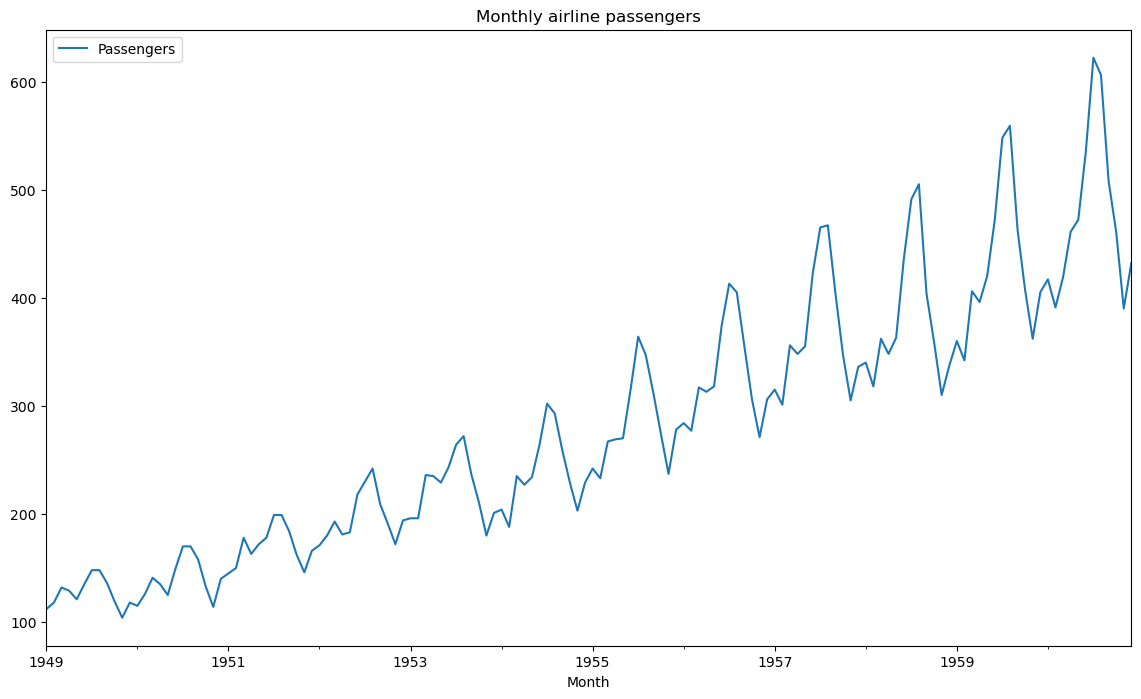

In [307]:
df.plot(figsize=(14,8), title= 'Monthly airline passengers');

pandas şu an onu numpya cevirelim

In [308]:
data = df["Passengers"].values

In [309]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [310]:
type(data[0:5])

numpy.ndarray

float 64 ü float 32 ye çevireceğiz

In [311]:
type(data[0])

numpy.float64

In [312]:
data = data.astype('float32')

In [313]:
type(data[0])

numpy.float32

In [314]:
data.shape

(144,)

In [315]:
data= data.reshape(-1,1)

In [316]:
data.shape

(144, 1)

train-test

In [317]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1-test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [318]:
train, test, position = split_data(data, 0.33)

In [319]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [320]:
scaler_train = MinMaxScaler(feature_range=(0,1))
train = scaler_train.fit_transform(train)

In [321]:
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

In [322]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [323]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [324]:
def create_features(data, lookbak):
    X, Y = [], []
    for i in range(lookbak, len(data)):
        X.append(data[i-lookbak:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

In [325]:
lookback = 1

In [326]:
# train veri seti
X_train, Y_train = create_features(train, lookback)
# test veri seti
X_test, Y_test = create_features(test, lookback)


In [327]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(95, 1) (95,) (47, 1) (47,)


RNN gelen veririnin 3 boyutlu yapida olasmını  istiyor

In [ ]:
X_train= np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test= np.reshape(X_test, (X_test.shape[0], 1, X_train.shape[1]))
Y_train= Y_train.reshape(-1,1)
Y_test=Y_test.reshape(-1,1)

In [329]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


4. Modelleme

In [330]:
model = Sequential()

model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)
                    ))
model.add(Dropout(0.2)) #aşşırı öğrenmeyi önemek için
model.add(Dense(1)) # cıktımızı tek bir değer olarka beklediğimizden tek bir dense yapitk

In [331]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [332]:
#optimiasyon ve Değerlendrime Metrikelrini Ayarlanması
model.compile(loss='mean_squared_error', optimizer='adam')

In [333]:
callbacks= [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'), ModelCheckpoint(filepath='mymodel.keras', monitor='val_loss', mode ='min', save_best_only=True, save_weights_only=False, verbose=1)]

In [334]:
history= model.fit(x= X_train, y= Y_train, epochs=50, batch_size=1, validation_data=(X_test, Y_test), callbacks= callbacks, shuffle=False)

Epoch 1/50
90/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 1: val_loss improved from inf to 0.03146, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0065 - val_loss: 0.0315
Epoch 2/50
93/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212
Epoch 2: val_loss improved from 0.03146 to 0.02813, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0281
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 3: val_loss improved from 0.02813 to 0.02071, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.0207
Epoch 4/50
92/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 4: val_loss did not improve from 0.02071
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0208
Epoch 5/50
73/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 5: val_loss did not improve from 0.02071
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

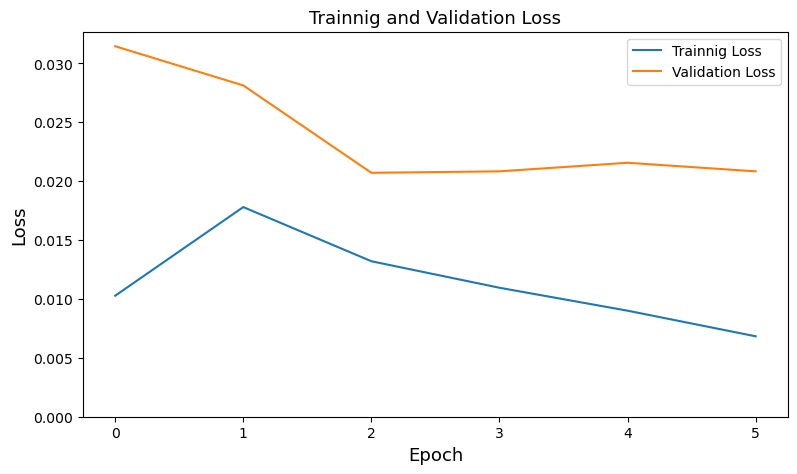

In [335]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Trainnig Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch', fontsize= 13)
plt.ylabel('Loss', fontsize= 13)
plt.ylim([0, max(plt.ylim())])
plt.title('Trainnig and Validation Loss', fontsize= 13)
plt.show()

5. Model Değerlendirme(Evulation)

In [336]:
loss= model.evaluate(X_test, Y_test, batch_size=1)
print("n\Test loss: %.1f%%"%(100.0 * loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163
n\Test loss: 2.1%


In [337]:
train_predict = model.predict(X_train)
test_predict= model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


scaler ile standartlaştirama ile geriye doğru götürüyoruz

In [338]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [339]:
Y_train = scaler_train.inverse_transform(Y_train)
y_test= scaler_test.inverse_transform(Y_test)

In [340]:
train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [341]:
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:23.133405685424805
Test RMSE:46.33713150024414


In [342]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [343]:
train_prediction_df= result_df[lookback: position]
train_prediction_df["Predicted"] = train_predict

In [344]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,126.680923
1949-03-01,132.0,131.003815
1949-04-01,129.0,143.736572
1949-05-01,121.0,140.967789
1949-06-01,135.0,133.584366


In [345]:
test_prediction_df= result_df[lookback + position:]
test_prediction_df["Predicted"] = test_predict

In [346]:
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,328.594788
1957-03-01,356.0,320.479065
1957-04-01,348.0,366.195190
1957-05-01,355.0,358.811829
1957-06-01,422.0,365.272308


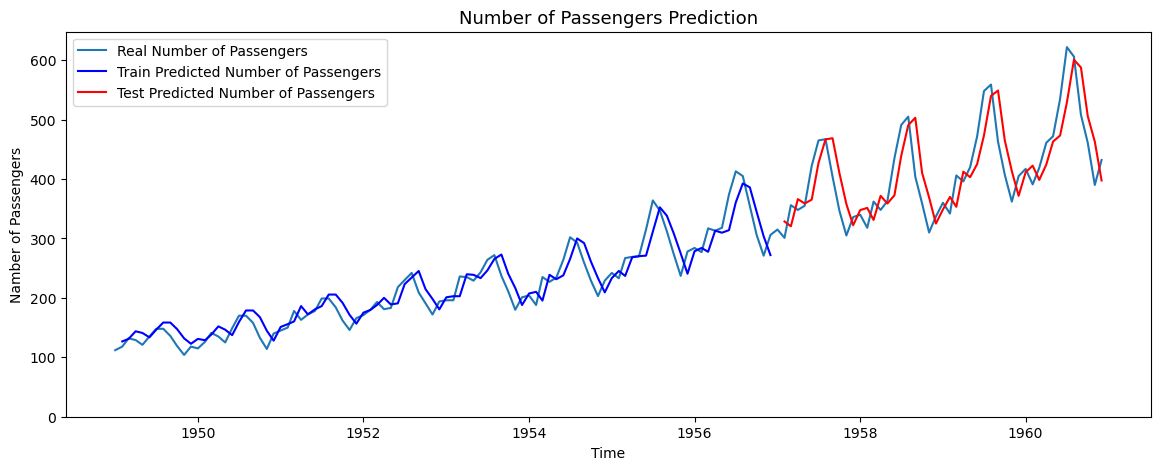

In [347]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label='Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color='blue', label= 'Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color='red', label= 'Test Predicted Number of Passengers')
plt.xlabel('Time')
plt.ylabel('Namber of Passengers')
plt.ylim([0, max(plt.ylim())])
plt.title('Number of Passengers Prediction', fontsize= 13)
plt.legend()
plt.show()